In [1]:
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.utils import generic_utils
from keras.callbacks import ModelCheckpoint
import numpy as np
import scipy 
import math
import h5py
import time
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

Using TensorFlow backend.


In [2]:
syn_df = pd.read_csv('Synthetic_Data\simple_syn_combined_0.1sd_6_eth.csv')
print(syn_df.shape)
print(syn_df.columns)
print(syn_df.iloc[0:5, :])

(140000, 20)
Index(['Unnamed: 0', 'id', 'quarter', 'ag_age', 'ag_sex', 'ag_eth', 'pt_nzdep',
       'imp_hxdiab', 'pt_tc_hdl_ratio', 'pt_bps', 'pt_bpd', 'pt_smoke',
       'imp_hxcvd', 'imp_hdl', 'imp_ldl', 'imp_tchol', 'PH_BL_LLD_ANY',
       'PH_BL_AHT_ANY', 'pt_familyhistory', 'tchdl'],
      dtype='object')
   Unnamed: 0     id  quarter    ag_age  ag_sex ag_eth  pt_nzdep  imp_hxdiab  \
0           0  10000        0  39.14871  Female    Oth         3           0   
1           1  10000        1  39.39871  Female    Oth         3           0   
2           2  10000        2  39.64871  Female    Oth         3           0   
3           3  10000        3  39.89871  Female    Oth         3           0   
4           4  10000        4  40.14871  Female    Oth         3           0   

   pt_tc_hdl_ratio    pt_bps    pt_bpd  pt_smoke  imp_hxcvd   imp_hdl  \
0         2.718664  113.6584  84.20549         0          0  1.623589   
1         2.718664  113.6584  84.20549         0          0 

In [3]:
# check categorical variables
print(syn_df.ag_sex.unique())
print(syn_df.ag_eth.unique())
syn_v = syn_df.values
print(syn_v.shape)

['Female' 'Male']
['Oth' 'Eur' 'Mao' 'Pac' 'Ind' 'Chi']
(140000, 20)


In [4]:
# one hot encode categorical variables 
for i in range(len(syn_v)):
    if syn_v[i, 4] == 'Male':
        syn_v[i, 4] = 0
    else:
        syn_v[i, 4] = 1
        
eth_v = np.zeros((140000, 6))
eth_idx = {'Chi': 0,
           'Eur': 1,
           'Ind': 2,
           'Mao': 3,
           'Oth': 4,
           'Pac': 5}

for i in range(len(syn_v)):
    eth_v[i, eth_idx[syn_v[i, 5]]] = 1

syn_v_1 = syn_v[:, 1:5]
syn_v_2 = syn_v[:, 6:]
syn_encoded_v = np.append(syn_v_1, eth_v, axis=1)
syn_encoded_v = np.append(syn_encoded_v, syn_v_2, axis=1)
print(syn_encoded_v.shape)
print(syn_encoded_v[0:5, :])

(140000, 24)
[[10000 0 39.148709999999994 1 0.0 0.0 0.0 0.0 1.0 0.0 3 0 2.718664
  113.6584 84.20549 0 0 1.623589 2.875279 4.378786 0 0 0
  2.720196946511845]
 [10000 1 39.398709999999994 1 0.0 0.0 0.0 0.0 1.0 0.0 3 0 2.718664
  113.6584 84.20549 0 0 1.623589 2.875279 4.378786 0 0 0
  2.6845696488452173]
 [10000 2 39.648709999999994 1 0.0 0.0 0.0 0.0 1.0 0.0 3 0 2.718664
  113.6584 84.20549 0 0 1.623589 2.875279 4.378786 0 0 0
  2.4842479478513715]
 [10000 3 39.898709999999994 1 0.0 0.0 0.0 0.0 1.0 0.0 3 0 2.718664
  113.6584 84.20549 0 0 1.623589 2.875279 4.378786 0 0 0
  2.653316792905103]
 [10000 4 40.148709999999994 1 0.0 0.0 0.0 0.0 1.0 0.0 3 0 2.718664
  113.6584 84.20549 0 0 1.623589 2.875279 4.378786 0 0 0
  2.7603294723172174]]


In [5]:
# normalise vectors to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(syn_encoded_v)

C:\Users\whsu014\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
###############################################
# set up data for training with generator
# build x and y list
###############################################
x_list = []
y_list = []
x = np.empty([0, 24])
ground_truth = np.empty([0, 24])
##################
entry_start = 0
len_list = [0]
len_list_x = [0]
len_list_y = [0]
id_count = 0
##################
number_of_inds = 5000
for i in range(number_of_inds):
    start = i*28
    end = (i+1)*28
    ind_data = scaled[start:end, :]
    ##################################
    # create ground truth for forecast
    ##################################
    id_count += 1
    ind_x = ind_data[:-1, :-1]
    ind_y = ind_data[1:, -1:]
    ind_xy = np.append(ind_x, ind_y, axis=1)
    ground_truth = np.append(ground_truth, ind_xy, axis=0)
    ##################################
    # create data for 1 step forecast
    ##################################
    for j in range(len(ind_data)-1):
        x_list.append(ind_data[:(j+1), :])
        y_list.append(ind_data[(j+1), -1:])
        if j == len(ind_data)-2:
            x = np.append(x, x_list[-1], axis=0)
            n_rows = x_list[-1].shape[0]
            entry_start += n_rows
            len_list.append(entry_start)
    # store the indices to fold
    # changed from 10 fold to 2 fold 
    # due to amount of data and fair 
    # comparison with depmix
    if id_count % (number_of_inds//2) == 0 and \
        id_count != 0:
            len_list_x.append(len(x_list))
            len_list_y.append(len(y_list))

In [9]:
print(len(x_list))
print(len(y_list))
print(len(len_list_x))
print(len(len_list_y))
print(len_list_x)
print(len_list_y)
#print(len_list)

size = len(len_list)//2
print(size)
print("start", len_list[0])
print("end", len_list[size])
print(len(len_list))
print("start+end", len_list[0+size+size])
print(ground_truth.shape)
print('############################')

135000
135000
3
3
[0, 67500, 135000]
[0, 67500, 135000]
2500
start 0
end 67500
5001
start+end 135000
(135000, 24)
############################


Fold:  1
Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.02092, saving model to weights1.hdf5
 - 236s - loss: 0.0229 - val_loss: 0.0209
Epoch 2/50

Epoch 00002: val_loss improved from 0.02092 to 0.01620, saving model to weights1.hdf5
 - 231s - loss: 0.0160 - val_loss: 0.0162
Epoch 3/50

Epoch 00003: val_loss improved from 0.01620 to 0.01567, saving model to weights1.hdf5
 - 232s - loss: 0.0146 - val_loss: 0.0157
Epoch 4/50

Epoch 00004: val_loss improved from 0.01567 to 0.01389, saving model to weights1.hdf5
 - 234s - loss: 0.0138 - val_loss: 0.0139
Epoch 5/50

Epoch 00005: val_loss did not improve
 - 234s - loss: 0.0131 - val_loss: 0.0149
Epoch 6/50

Epoch 00006: val_loss did not improve
 - 232s - loss: 0.0127 - val_loss: 0.0157
Epoch 7/50

Epoch 00007: val_loss did not improve
 - 233s - loss: 0.0124 - val_loss: 0.0145
Epoch 8/50

Epoch 00008: val_loss did not improve
 - 234s - loss: 0.0121 - val_loss: 0.0199
Epoch 9/50

Epoch 00009: val_loss did not improve
 - 234s - loss: 0

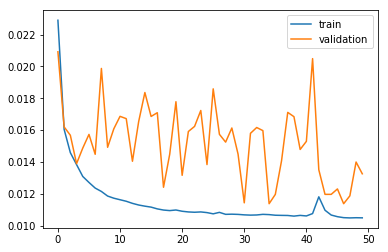

Training LSTM:  11667.850371599197
inv_y x and inv_yhat x are the same
Training and Testing LSTM:  11726.642488002777
End of fold 1: 11726.667520999908
Fold:  0
Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.02090, saving model to weights0.hdf5
 - 237s - loss: 0.0228 - val_loss: 0.0209
Epoch 2/50

Epoch 00002: val_loss improved from 0.02090 to 0.01693, saving model to weights0.hdf5
 - 233s - loss: 0.0154 - val_loss: 0.0169
Epoch 3/50

Epoch 00003: val_loss did not improve
 - 237s - loss: 0.0143 - val_loss: 0.0176
Epoch 4/50

Epoch 00004: val_loss improved from 0.01693 to 0.01396, saving model to weights0.hdf5
 - 236s - loss: 0.0135 - val_loss: 0.0140
Epoch 5/50

Epoch 00005: val_loss did not improve
 - 235s - loss: 0.0130 - val_loss: 0.0144
Epoch 6/50

Epoch 00006: val_loss improved from 0.01396 to 0.01393, saving model to weights0.hdf5
 - 234s - loss: 0.0124 - val_loss: 0.0139
Epoch 7/50

Epoch 00007: val_loss improved from 0.01393 to 0.01279, saving model to weights0.hdf5
 

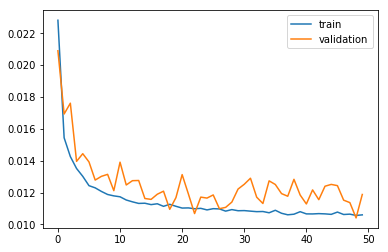

Training LSTM:  11742.154884338379
inv_y x and inv_yhat x are the same
Training and Testing LSTM:  11807.296389579773
End of fold 0: 11807.976719379425
rmse_lstm_list
Entire process took: 23535.77871990204


In [14]:
###########################################
# two fold cross validatioin
###########################################

# keras generators need to be 
# infinitely iterable
def train_generator(x_list, y_list):
    # 0.1 validatioin split
    train_length = (len(x_list)//10)*9
    while True:
        for i in range(train_length):
            train_x = np.array([x_list[i]])
            train_y = np.array([y_list[i]])
            yield train_x, train_y
            
def val_generator(x_list, y_list):
    # 0.1 validation split
    val_length = len(x_list)//10
    while True:
        for i in range(-val_length, 0, 1):
            val_x = np.array([x_list[i]])
            val_y = np.array([y_list[i]])
            yield val_x, val_y
            
start_idx = 0
size = len(len_list)//2 #changed from 10

rmse_lstm_list = []
#rmse_var_list = []
rmse_naive_list = []

complete_inv_y = np.empty([0, 24])
complete_inv_yhat = np.empty([0, 24])
#complete_inv_var = np.empty([0, 38])
complete_inv_naive = np.empty([0, 24])

start_outside = time.time()

for f in range(1, -1, -1): #2 (1, 0, -1)
    print("Fold: ", f)
    ##################################
    # forecast using LSTM
    ##################################
    lstm_start = len_list_x[f]
    lstm_end = len_list_x[f+1]
    
    train1_x = x_list[:lstm_start]
    train2_x = x_list[lstm_end:]
    train_x = train1_x + train2_x
    test_x = x_list[lstm_start:lstm_end]
    
    train1_y = y_list[:lstm_start]
    train2_y = y_list[lstm_end:]
    train_y = train1_y + train2_y
    test_y = y_list[lstm_start:lstm_end]
    
    # time training
    start_time = time.time()
    # design network
    model = Sequential()
    model.add(LSTM(64, return_sequences=False,
                   input_shape=(None, 24)))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    model_weights = "weights" + str(f) + ".hdf5"
    checkpointer = ModelCheckpoint(filepath=model_weights,
                                   monitor='val_loss', verbose=1,
                                   save_best_only=True)
    history = model.fit_generator(generator=train_generator(train_x,
                                                            train_y),
                                  steps_per_epoch=(len(train_x)//10)*9,
                                  epochs=50,
                                  validation_data=val_generator(train_x,
                                                                train_y),
                                  validation_steps=len(train_x)//10,
                                  callbacks=[checkpointer],
                                  verbose=2, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    end_time = time.time()
    print("Training LSTM: ", end_time - start_time)
    
    # LSTM prediction
    #multi-step forecast from quarter 8 onwards
    model.load_weights(model_weights)
    yhat = np.empty((0, 1))
    forecast = np.empty((0, 1))
    for i in range(len(test_x)):
        #print("test_x[i].shape", test_x[i].shape)
        #print("###############################")
        if len(test_x[i]) < 8:
            yhat_pred = model.predict(np.array([test_x[i]]))
        elif len(test_x[i]) == 8:
            yhat_pred = model.predict(np.array([test_x[i]]))
            forecast = np.append(forecast, yhat_pred, axis=0)
        elif len(test_x[i]) > 8:
            adjusted_y = np.append(test_x[i][:-len(forecast), -1:], 
                                   forecast, axis=0)
            test_x[i] = np.append(test_x[i][:, :-1], adjusted_y, axis=1)
            yhat_pred = model.predict(np.array([test_x[i]]))
            forecast = np.append(forecast, yhat_pred, axis=0)    
            if len(test_x[i]) == 27:
                forecast = np.empty((0, 1))
        #yhat_pred = model.predict(np.array([test_x[i]]))
        #print("yhat_pred.shape: ", yhat_pred.shape)
        yhat = np.append(yhat, yhat_pred, axis=0)
    start = len_list[start_idx]
    end = len_list[start_idx+size]
    xyhat = np.append(x[start:end, :-1], yhat, axis=1)
    inv_yhat = scaler.inverse_transform(xyhat)
    inv_y = scaler.inverse_transform(ground_truth[start:end, :])
    if np.array_equal(inv_y[:, :-1], inv_yhat[:, :-1]):
        print("inv_y x and inv_yhat x are the same")
    else:
        print("inv_y x and inv_yhat x are not the same")
    end_time = time.time()
    print("Training and Testing LSTM: ", end_time - start_time)
    #########################################################
    # forecasting using Vector Autoregression (VAR) and Naive
    #########################################################
    rmse_lstm = math.sqrt(mean_squared_error(inv_y[:, -1:], inv_yhat[:, -1:]))
    rmse_lstm_list.append(rmse_lstm)
    
    complete_inv_y = np.append(complete_inv_y, inv_y, axis=0)
    complete_inv_yhat = np.append(complete_inv_yhat, inv_yhat, axis=0)

    end_time = time.time()
    print("End of fold "+str(f)+":", end_time - start_time)
    start_idx += size
print("rmse_lstm_list")
end_outside = time.time()
print("Entire process took:", end_outside - start_outside)

In [12]:
print(rmse_lstm_list)
print(complete_inv_y.shape)
print(complete_inv_yhat.shape)

[0.5700346827847684, 0.4572687741379604]
(135000, 24)
(135000, 24)


In [15]:
print(rmse_lstm_list)
print(complete_inv_y.shape)
print(complete_inv_yhat.shape)

[1.7559744518116163, 1.9706701833307474]
(135000, 24)
(135000, 24)


In [16]:

complete_lstm_forecast_df = pd.DataFrame(complete_inv_yhat)
complete_lstm_forecast_df.columns = ['id', 'quarter', 'ag_age', 'ag_sex', 
                                     'Chi', 'Eur', 'Ind', 'Mao', 'Oth', 'Pac',
                                     'pt_nzdep', 'imp_hxdiab', 'pt_tc_hdl_ratio', 
                                     'pt_bps', 'pt_bpd', 'pt_smoke',
                                     'imp_hxcvd', 'imp_hdl', 'imp_ldl', 
                                     'imp_tchol', 'PH_BL_LLD_ANY',
                                     'PH_BL_AHT_ANY', 'pt_familyhistory',
                                     'tchdl']

complete_y_df = pd.DataFrame(complete_inv_y)
complete_y_df.columns = ['id', 'quarter', 'ag_age', 'ag_sex', 
                                     'Chi', 'Eur', 'Ind', 'Mao', 'Oth', 'Pac',
                                     'pt_nzdep', 'imp_hxdiab', 'pt_tc_hdl_ratio', 
                                     'pt_bps', 'pt_bpd', 'pt_smoke',
                                     'imp_hxcvd', 'imp_hdl', 'imp_ldl', 
                                     'imp_tchol', 'PH_BL_LLD_ANY',
                                     'PH_BL_AHT_ANY', 'pt_familyhistory',
                                     'tchdl']

complete_lstm_forecast_df.to_csv("simple_syn_LSTM_forecast.csv", sep=",")
complete_y_df.to_csv("simple_syn_ground_truth.csv", sep=",")